<a href="https://colab.research.google.com/github/Atharva-Gaykar/Deep_Learning/blob/main/notebooks/text_data/GPT2_SCRATCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np


In [ ]:
class Layer_Norm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

Here , gamma=1 [torch.ones(emb_dim)] ; beta=0 [torch.zeros(emb_dim)]

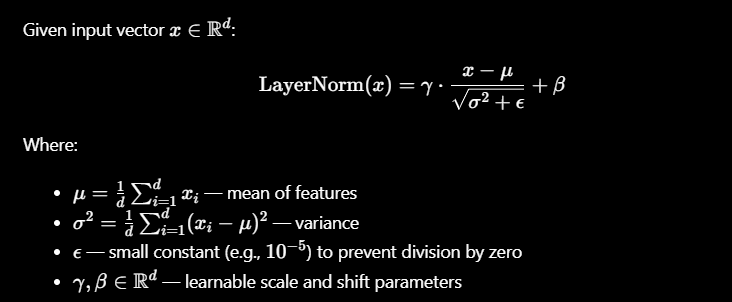

In [ ]:

batch_example = torch.tensor([
    [[1.0, 2.0, 3.0, 4.0, 5.0],
     [5.0, 4.0, 3.0, 2.0, 1.0]],

    [[2.0, 2.0, 2.0, 2.0, 2.0],
     [0.0, 1.0, 2.0, 3.0, 4.0]]
])


ln = Layer_Norm(emb_dim=5)


out_ln = ln(batch_example)

mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True, unbiased=False)

print("🔹 Original Input (Before Normalization):\n", batch_example)
print("\n✅ Output After LayerNorm:\n", out_ln)
print("\n📊 Mean After Normalization:\n", mean)
print("\n📉 Variance After Normalization:\n", var)

🔹 Original Input (Before Normalization):
 tensor([[[1., 2., 3., 4., 5.],
         [5., 4., 3., 2., 1.]],

        [[2., 2., 2., 2., 2.],
         [0., 1., 2., 3., 4.]]])

✅ Output After LayerNorm:
 tensor([[[-1.4142, -0.7071,  0.0000,  0.7071,  1.4142],
         [ 1.4142,  0.7071,  0.0000, -0.7071, -1.4142]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.4142, -0.7071,  0.0000,  0.7071,  1.4142]]],
       grad_fn=<AddBackward0>)

📊 Mean After Normalization:
 tensor([[[0.],
         [0.]],

        [[0.],
         [0.]]], grad_fn=<MeanBackward1>)

📉 Variance After Normalization:
 tensor([[[1.0000],
         [1.0000]],

        [[0.0000],
         [1.0000]]], grad_fn=<VarBackward0>)


In [ ]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

The above gelu function is the mathematical approximation used -

the derivative calculation during backpropogation is amde easy by using such approximations-

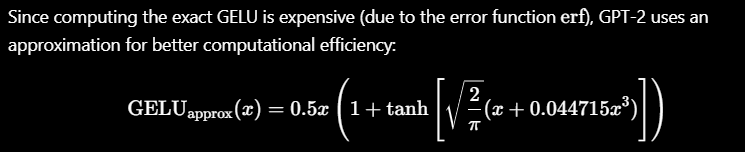

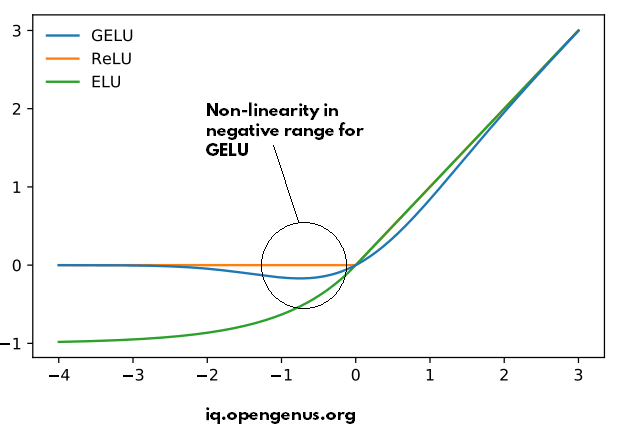

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

# Shape Explanation for Feed Forward Layer in GPT-2

For the samples in a batch (ignoring batch size for clarity):

1. First Linear Layer:

   (seq_length, embedding_dim) · (embedding_dim, 4 × embedding_dim)
   → (seq_length, 4 × embedding_dim)

   # Explanation:
   Each token’s embedding (of shape embedding_dim) is transformed into a higher-dimensional space.

2. Second Linear Layer:

   (seq_length, 4 × embedding_dim) · (4 × embedding_dim, embedding_dim)
   → (seq_length, embedding_dim)

   # Explanation:
   Projects the high-dimensional representation back to the original embedding size.


In [ ]:
class Multi_Head_Attention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        #this is to make sure that mask size should not be too big if the num_tokens < context_length
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        #contigous is required to maintain the same  memory blocks.
        # We are converting back to origanal input shape.
        context_vec = self.out_proj(context_vec)

        return context_vec

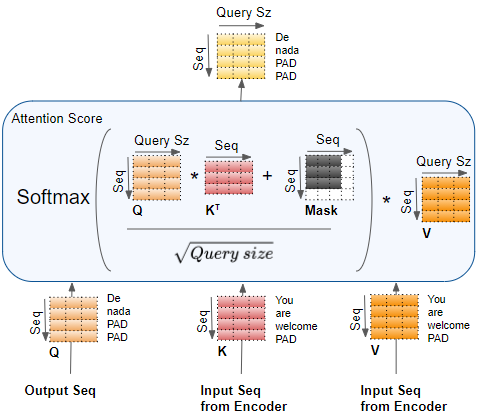



---

🧩 INPUTS:
- d_in         : Input embedding dimension
- d_out        : Output embedding dimension (must be divisible by num_heads)
- num_heads    : Number of parallel attention heads
- context_length: Maximum sequence length (used for mask)
- dropout      : Dropout probability on attention weights
- qkv_bias     : Whether to add bias in Q, K, V projection layers

---

🛠️ Initialization:

1. Linear projections for Q, K, V:
   - W_query = Linear(d_in, d_out)
   - W_key   = Linear(d_in, d_out)
   - W_value = Linear(d_in, d_out)

2. Output projection:
   - out_proj = Linear(d_out, d_out)

3. Causal mask:
   - mask = upper triangular matrix of shape (context_length, context_length) with 1s above the diagonal.

---

🚀 Forward Pass:

Given input x of shape (batch_size, seq_len, d_in):

1. Compute Q, K, V:
   - queries = W_query(x) → (b, seq_len, d_out)
   - keys    = W_key(x)
   - values  = W_value(x)

2. Reshape for multiple heads:
   - Split d_out into (num_heads, head_dim) where head_dim = d_out // num_heads
   - New shape: (b, num_heads, seq_len, head_dim)

3. Compute Scaled Dot-Product Attention for each head:

   Attention Score Formula (before softmax):
   ⮞ **A[i,j] = (Q · Kᵗ) / √d_k**

   - attn_scores = Q @ Kᵗ → shape: (b, num_heads, seq_len, seq_len)

4. Apply Causal Mask:
   - Prevent attention to future tokens
   - Fill upper triangle with -inf before softmax
   - Final: attn_scores.masked_fill(mask_bool, -inf)

5. Compute Attention Weights:
   - attn_weights = softmax(attn_scores / √head_dim)
   - Apply dropout

6. Compute Context Vectors:
   - context_vec = attn_weights @ V → (b, num_heads, seq_len, head_dim)
   - Transpose & reshape back to (b, seq_len, d_out)
   - Pass through final linear projection

---

📏 Output:
- context_vec: Tensor of shape (b, seq_len, d_out)







### 🔐 **Masked Multi-Head Self-Attention (No Relative Position Bias)**

#### ✅ Formula:

$$
\text{MaskedAttention}(Q, K, V) = \text{softmax}\left( \frac{QK^T}{\sqrt{d_k}} + M \right) V
$$

---

#### 📘 Explanation of Terms:

* $Q, K, V \in \mathbb{R}^{b \times h \times L \times d}$

  * $b$: batch size
  * $h$: number of attention heads
  * $L$: sequence length (number of tokens)
  * $d$: head dimension (usually $d_k = d_{\text{model}} / h$)

* $QK^T \in \mathbb{R}^{b \times h \times L \times L}$

  * Dot-product between query and key for each head

* $\sqrt{d_k}$: scaling factor for stability during training

* $M \in \mathbb{R}^{L \times L}$: **causal attention mask**, where

  $$
  M_{i,j} =
  \begin{cases}
    0 & \text{if } j \leq i \quad (\text{token } j \text{ is visible to } i) \\
    -\infty & \text{if } j > i \quad (\text{future tokens are masked})
  \end{cases}
  $$

* **softmax** is applied across the last dimension (i.e., over all tokens in the sequence)

* $V \in \mathbb{R}^{b \times h \times L \times d}$: the value matrix

---

#### 🎯 Purpose of the Mask:

* Ensures **causality**: each token can only attend to itself and previous tokens, **not future tokens**
* Essential for autoregressive models like **GPT**, **decoder-only transformers**




In [ ]:
import torch
import torch.nn as nn


torch.manual_seed(123)

inputs = torch.tensor(
    [[0.43, 0.15, 0.89, 0.55, 0.87, 0.66, 0.12, 0.34],
     [0.57, 0.85, 0.64, 0.22, 0.58, 0.33, 0.44, 0.19],
     [0.77, 0.25, 0.10, 0.05, 0.80, 0.55, 0.31, 0.27]],
    dtype=torch.float32
)



batch = torch.stack((inputs, inputs), dim=0)
print("batch.shape:", batch.shape)

batch_size, context_length, d_in = batch.shape
d_out = 8
num_heads = 2

mha = Multi_Head_Attention(d_in, d_out, context_length, dropout=0.0, num_heads=num_heads)

context_vecs = mha(batch)
print("context_vecs:\n", context_vecs)
print("context_vecs.shape:", context_vecs.shape)


batch.shape: torch.Size([2, 3, 8])
context_vecs:
 tensor([[[ 0.2735, -0.4941,  0.5568,  0.1859, -0.1699,  0.0326,  0.0900,
           0.3106],
         [ 0.2507, -0.5053,  0.5292,  0.1700, -0.1464,  0.0035,  0.1774,
           0.3341],
         [ 0.2229, -0.4936,  0.5165,  0.1385, -0.1268,  0.0624,  0.2020,
           0.3613]],

        [[ 0.2735, -0.4941,  0.5568,  0.1859, -0.1699,  0.0326,  0.0900,
           0.3106],
         [ 0.2507, -0.5053,  0.5292,  0.1700, -0.1464,  0.0035,  0.1774,
           0.3341],
         [ 0.2229, -0.4936,  0.5165,  0.1385, -0.1268,  0.0624,  0.2020,
           0.3613]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 3, 8])


In [ ]:
GPT_CONFIG = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.05,
    "qkv_bias": False
}

In [ ]:
class Transformer_Block(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = Multi_Head_Attention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = Layer_Norm(cfg["emb_dim"])
        self.norm2 = Layer_Norm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):

        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut


        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

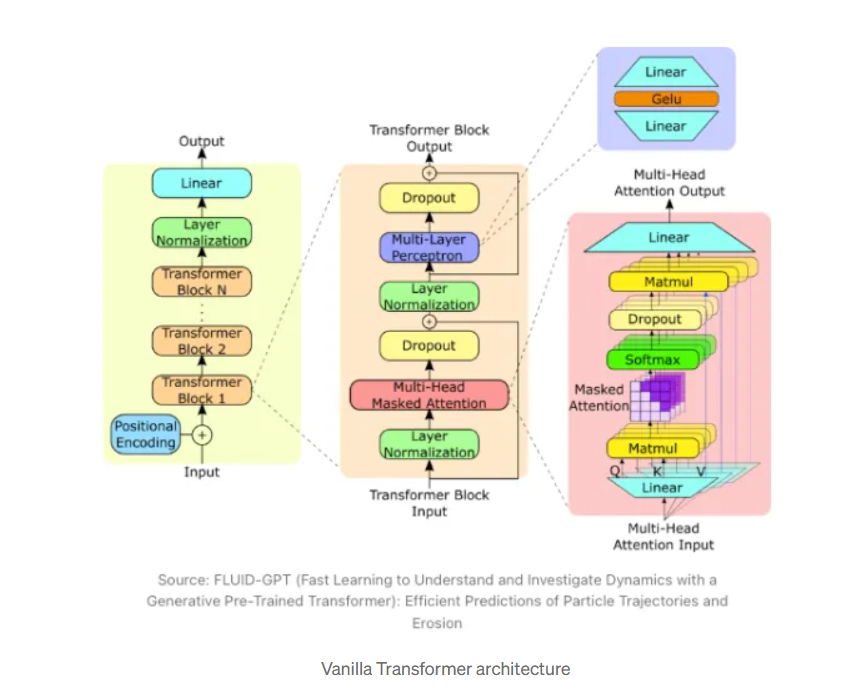

In [ ]:
class GPT_Model(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[Transformer_Block(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = Layer_Norm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [ ]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  #
sentences = [
    "Shivaji Maharaj was a great warrior.",
    "He founded the Maratha Empire.",

]

# Tokenize and pad/truncate to context_length
encoded = tokenizer(
    sentences,
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=GPT_CONFIG["context_length"]
)

batch = encoded["input_ids"]  # shape: [batch_size, context_length]


In [ ]:
torch.manual_seed(123)
model = GPT_Model(GPT_CONFIG)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[ 2484,   452, 26436, 31692,  1228,   373,   257,  1049, 16491,    13,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [ ]:
start_context = "How are you ?"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) #A
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [2437, 389, 345, 5633]
encoded_tensor.shape: torch.Size([1, 4])


In [ ]:
model.eval()
out = generate_text_simple(
model=model,
idx=encoded_tensor,
max_new_tokens=6,
context_size=GPT_CONFIG["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[ 2437,   389,   345,  5633, 24075, 41835, 24842, 36661,  2381, 19800]])
Output length: 10


In [ ]:
model = GPT_Model(GPT_CONFIG)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open("/content/drive/MyDrive/text_data.txt", "r") as f:
    text_data = f.read()

In [ ]:
from transformers import GPT2Tokenizer
from torch.utils.data import Dataset, DataLoader
import torch

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize entire text (do NOT truncate here)
        token_ids = tokenizer.encode(
            txt,
            add_special_tokens=False
        )

        # Slide window and create input/target pairs
        for i in range(0, len(token_ids) - max_length, stride):
            if i + max_length + 1 > len(token_ids):
                break  # Avoid mismatch in target length

            input_chunk = token_ids[i : i + max_length]
            target_chunk = token_ids[i + 1 : i + max_length + 1]

            self.input_ids.append(torch.tensor(input_chunk, dtype=torch.long))
            self.target_ids.append(torch.tensor(target_chunk, dtype=torch.long))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(txt, batch_size=4, max_length=128,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Load tokenizer and assign pad token
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    tokenizer.pad_token = tokenizer.eos_token

    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader


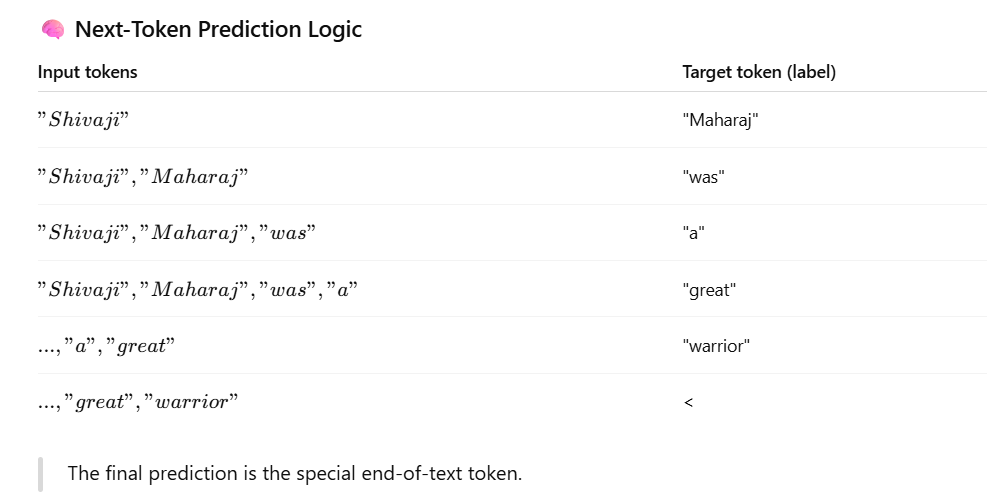

In [ ]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG["context_length"],
    stride=GPT_CONFIG["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=1,
    max_length=GPT_CONFIG["context_length"],
    stride=GPT_CONFIG["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

Token indices sequence length is longer than the specified maximum sequence length for this model (2212 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

print(len(train_loader))
print(len(val_loader))


Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
4
0


In [ ]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 2048
Validation tokens: 0
All tokens: 2048


In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss



In [ ]:

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [ ]:
import torch
from torch import nn, optim

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = GPT_Model(GPT_CONFIG).to(device)

# Loss: CrossEntropy for next-token prediction
loss_fn = nn.CrossEntropyLoss()

# Optimizer: GPT-2 used Adam with specific betas and weight decay
optimizer = optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.95), weight_decay=0.1)

# Optional: Learning rate scheduler (linear warmup + decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)  # basic example


In [ ]:
num_epochs = 15
model.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    for input_batch, target_batch in train_loader:
        # 🔁 Compute loss
        loss = calc_loss_batch(input_batch, target_batch, model, device)

        # 🧠 Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Avg Loss: {total_loss / len(train_loader):.4f}")


Epoch 1 | Avg Loss: 9.7273
Epoch 2 | Avg Loss: 7.9074
Epoch 3 | Avg Loss: 6.6002
Epoch 4 | Avg Loss: 5.2100
Epoch 5 | Avg Loss: 4.3280
Epoch 6 | Avg Loss: 3.3504
Epoch 7 | Avg Loss: 2.5715
Epoch 8 | Avg Loss: 1.9217
Epoch 9 | Avg Loss: 1.3848
Epoch 10 | Avg Loss: 0.9538
Epoch 11 | Avg Loss: 0.6693
Epoch 12 | Avg Loss: 0.4190
Epoch 13 | Avg Loss: 0.2769
Epoch 14 | Avg Loss: 0.1893
Epoch 15 | Avg Loss: 0.1370


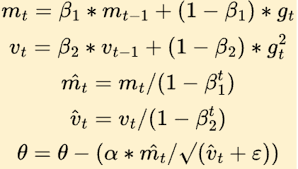

In [ ]:
def generate_text(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

MULTINOMIAL DISTRIBUTION

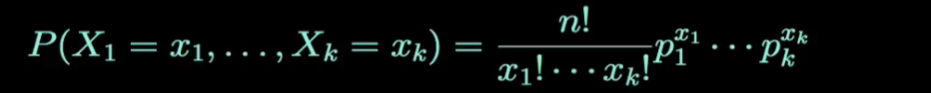

## 🔥 Temperature Scaling + Top-k Sampling in GPT-2 Decoding

---

### 📌 Overview

GPT-2 generates text one token at a time. To predict the next token, it calculates a raw score (called a *logit*) for every token in its vocabulary. These logits are then converted into probabilities using the softmax function, forming a probability distribution over the entire vocabulary.

The model then samples the next token from this distribution, making it a **categorical distribution** — a type of distribution where each possible outcome (token) has a specific probability.

---

### 🧠 Formula Behind the Distribution

The softmax function converts raw logits \( z_i \) into probabilities \( p_i \) as follows:

$$
p_i = \frac{e^{z_i/T}}{\sum_{j=1}^{V} e^{z_j/T}}
$$

Where:

- \( z_i \) is the logit for token \( i \),
- \( T \) is the temperature (a scaling factor),
- \( V \) is the size of the vocabulary.

This gives a probability for each token:

$$
P(X = x_i) = p_i
$$

This is the categorical probability of sampling token \( x_i \).

---

### 🌡️ Temperature Scaling

Temperature scaling adjusts the model's confidence in its predictions:

- When \( T < 1 \), the model becomes more confident and focuses on high-probability tokens.
- When \( T > 1 \), the model becomes more exploratory and allows more diverse token selection.
- When \( T = 1 \), there is no change.

The logits are scaled before applying softmax:

$$
z_i' = \frac{z_i}{T}
$$

Then these scaled logits are used to compute \( p_i \).

---

### 🎯 Top-k Sampling

Top-k sampling is a decoding strategy that limits the sampling space to only the top-k tokens with the highest probabilities:

1. From the full vocabulary, select only the top-k tokens with the highest probabilities.
2. Set the probabilities of all other tokens to zero.
3. Renormalize the remaining probabilities so they sum to 1.
4. Sample one token from this reduced distribution.

This helps avoid selecting low-probability or irrelevant tokens, while still allowing diversity.

---

### 🧪 Example

Suppose GPT-2 is given the prompt: `"The sky is"`  
After applying softmax (with temperature), the model assigns the following probabilities:

| Token       | Probability |
|-------------|-------------|
| "blue"      | 0.35        |
| "dark"      | 0.25        |
| "beautiful" | 0.15        |
| "clouds"    | 0.10        |
| "red"       | 0.08        |
| "sky"       | 0.07        |

If we use **Top-k sampling with \( k = 3 \)**, we keep only:

- "blue": 0.35  
- "dark": 0.25  
- "beautiful": 0.15  

These are renormalized:

$$
\text{New total} = 0.35 + 0.25 + 0.15 = 0.75
$$

$$
P("blue") = \frac{0.35}{0.75} \approx 0.47 \\
P("dark") = \frac{0.25}{0.75} \approx 0.33 \\
P("beautiful") = \frac{0.15}{0.75} \approx 0.20
$$

Now, the model samples the next word randomly from these three, based on the new probabilities. Each run may yield a different output like:

- "The sky is blue"
- "The sky is dark"
- "The sky is beautiful"

---

### 🧮 Multinomial Distribution (Optional)

The sampling process can also be described using the multinomial distribution. In general:

$$
P(X_1 = x_1, ..., X_k = x_k) = \frac{n!}{x_1! \cdots x_k!} \cdot p_1^{x_1} \cdots p_k^{x_k}
$$

In GPT-2, since only **one token is sampled at a time** (\( n = 1 \)), this simplifies to the **categorical distribution**:

$$
P(X = x_i) = p_i
$$

---

### ✅ Summary

- GPT-2 produces logits → apply temperature scaling → filter to top-k tokens → normalize and sample one.
- Temperature controls the randomness of the output.
- Top-k focuses sampling on the most likely tokens.
- Together, they improve diversity and quality in text generation.


In [ ]:
import torch

# ================================
# 🔁 Text-to-token utility
# ================================
def text_to_token_ids(text, tokenizer):
    """
    Convert input text to token IDs.
    Returns tensor of shape (1, sequence_length).
    """
    input_ids = tokenizer.encode(text, return_tensors='pt')
    return input_ids


# ================================
# 🔁 Token-to-text utility
# ================================
def token_ids_to_text(token_ids, tokenizer):
    """
    Convert generated token IDs to readable text.
    """
    return tokenizer.decode(token_ids[0], skip_special_tokens=True)


# ================================
# 🧠 GPT-like generate function
# ================================
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    """
    Generate new tokens from a model using temperature scaling and top-k sampling.
    """
    device = next(model.parameters()).device  # Get model's device
    idx = idx.to(device)

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)  # shape: (B, T, V)

        logits = logits[:, -1, :]  # Get logits at last position only (B, V)

        # ----- Top-k Filtering -----
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1].unsqueeze(1)
            logits = torch.where(logits < min_val, torch.tensor(float("-inf"), device=device), logits)

        # ----- Temperature Sampling -----
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # Greedy (B, 1)

        # ----- EOS Token Handling -----
        if eos_id is not None and (idx_next == eos_id).all():
            break

        idx = torch.cat((idx, idx_next), dim=1)

    return idx


In [ ]:
# Prompt
prompt = "Cancer is a complex and multifaceted group of diseases characterized  "

# Set seed for reproducibility
torch.manual_seed(123)

# Convert prompt to token ids
input_ids = text_to_token_ids(prompt, tokenizer)

# Generate tokens
token_ids = generate(
    model=model,
    idx=input_ids,
    max_new_tokens=15,
    context_size=GPT_CONFIG["context_length"],
    temperature=1.4,
    top_k=25,
    eos_id=tokenizer.eos_token_id  # Optional
)

# Decode output
output_text = token_ids_to_text(token_ids, tokenizer)

# Print result
print("Output text:\n", output_text)


Output text:
 Cancer is a complex and multifaceted group of diseases characterized  

It of cell as like bone, a future genes, parasites account
